### **Gaussian Beam Profile Extraction**
    Sean Keenan, 5th Year MPhys Heriot-Watt University, Edinburgh
    Quantum memories group - QPL Heriot-Watt

load image files and read camera position data from designated
folder to produce gaussian fit in x and y dimensions. Fit data
can then be plotted against the original image and / or saved
to excel file. Due to compatibility issues input data files
should be of the format .xlsx


In [1]:
# import relevant modules
import os
import numpy as np
import pandas as pd
from natsort import natsorted
from PIL import Image
import matplotlib.pyplot as mp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import fit_funcs as ff
import sys

# to save data / plots and to show plots
excel_save = True
plot_show = False
plot_save = False

# quick waist calculation - no waist fit / find
quick_show = False

Folder to draw files from and save data to

In [2]:
# directory and folder for images
dir = r"C:\Users\sk88\Dropbox (Heriot-Watt University Team)\RES_EPS_Quantum_Photonics_Lab\Experiments\Current Experiments\BB Telecom QM\1550 AOM alignment\20220412_6.2mm_collimated_beam_diameters_for_1550_AOM"
folder = "test1"
# image laser wavelength(mm)
ff.wavelength = 1550e-6
# chip and pixel size (mm) if known (Hamamatsu 9.6 x 7.68 mm, DK 1.411cm)
chip_size =  9.6 # 14.11 #


This section loops through the images in the specified folder (they should be labelled 1, 2, 3 etc.) with
the background image given after the relevant beam image. i.e. background images are even,
beam images are odd. The file containing the image positions should be labelled 'Distance (mm)'
with the distances given in mm.

The output file for the beam waist and rayleigh range calulations will be the same as the
file containing the distance for each image. Due to compaibility issues this shoul always be
of the format .xlsx


In [3]:
# set file path
path = dir + '\\' + folder + '\\'
file_list = os.listdir(path)
# extract relevant files and sort in order
image_list = natsorted([i for i in file_list if i.endswith(('.bmp', '.tif'))])
# determine length of arrays needed
array_len = int(len(image_list)/2)
# find the excel file with position data - write to this later

# determine array dimensions for new data
img = Image.open(path + image_list[0])
imsize = img.size
# calculate the dimensions per pixel (um)
pix_size = chip_size / imsize[0]

if quick_show == 0:
    xl_file = [i for i in file_list if i.endswith('.xlsx')]
    # display error if file incorrect format
    if not xl_file:
        sys.exit('Excel file does not exist or must be of format ".xlsx"')
    
    # extract sheet with position data
    xlsx = pd.ExcelFile(path + xl_file[0])
    # read z-position data
    z_pos = pd.read_excel(xlsx, sheet_name='Sheet1', usecols=['Distance (mm)'])
    # remove nan form data frame
    z_pos = z_pos.dropna()
    # remove duplicate positions
    z = z_pos.drop_duplicates()
    # reshape array to match other
    z = np.reshape(z.to_numpy(), len(z))

    # warn user if insufficient data to continue
    if len(image_list) % 2 != 0:
        sys.exit('Number of image files must be even')
    elif len(z) != len(image_list)/2:
        sys.exit('Number of images and z-distance mismatch')

### Read image and subtract background data

Reads each image, subtracting the relevant background image in-turn, before fitting the
data with a Gaussian in both x and y. 

In [4]:
# create empty arrays for new data
data = np.empty([array_len, imsize[0], imsize[1]])
fit_data = np.empty([array_len, 2, 3])
fit_err = np.empty([array_len, 2, 3])

# check input image type - fitting only works for grayscale image
flag = 0
if not Image.open(path + image_list[0]).mode in ('I;16', 'L'):
    flag = 1

# read image and subtract background - store in new arrays
for index, image in enumerate(image_list):
    if flag == 1:
        # break when half way through image list
        if index < array_len:
            # read then discard image (change to float64 as uint8 does not have -ve values)
            img = Image.open(path + image_list[2 * index])
            img = np.float64(np.transpose(np.asarray(img.convert(mode='L',matrix =None, dither=None, palette=0, colors=256))))
            bkd = Image.open(path + image_list[2 * index + 1])
            bkd = np.float64(np.transpose(np.asarray(bkd.convert(mode='L',matrix =None, dither=None, palette=0, colors=256))))    
            # arrays of data, gaussian params, fit and error
            data[index, :, :] = np.absolute(img - bkd)
            # scale data to maximum 255
            data[index, :, :] *= 255/data[index, :, :].max()
            fit_data[index, :, :], fit_err[index, :, :] = ff.fitgauss(data[index, :, :])
    else:
        # break when half way through image list
        if index < array_len:
            # read then discard image (change to float64 as uint8 does not have -ve values)
            img = np.float64(np.transpose(np.asarray(Image.open(path + image_list[2 * index]))))
            bkd = np.float64(np.transpose(np.asarray(Image.open(path + image_list[2 * index + 1]))))
            # arrays of data, gaussian params, fit and error
            data[index, :, :] = np.absolute(img - bkd)
            # scale data to maximum 255
            data[index, :, :] *= 255/data[index, :, :].max()
            fit_data[index, :, :], fit_err[index, :, :] = ff.fitgauss(data[index, :, :])

# convert data to um & remove negatives
scale_data = np.abs(fit_data) * pix_size
scale_err = np.abs(fit_err) * pix_size

# calcualate percent error
FWHM_err = np.array(scale_err[:, :, 2] / scale_data[:, :, 2])
# calculate FWHM & 1/e^2 (um)
FWHM = 2 * np.sqrt(2 * scale_data[:, :, 2] ** 2 * np.log(2)) 
FWHM_x = np.reshape(FWHM[:,0], (len(FWHM),1))
FWHM_xerr = np.reshape(FWHM_err[:, 0] * np.ravel(FWHM_x), (len(FWHM),1))
FWHM_y = np.reshape(FWHM[:,1], (len(FWHM),1))
FWHM_yerr = np.reshape(FWHM_err[:, 1] * np.ravel(FWHM_y),  (len(FWHM),1))
over_e2x = np.sqrt(2/np.log(2)) * FWHM_x
e2x_err = np.sqrt(2/np.log(2)) * FWHM_xerr
over_e2y = np.sqrt(2/np.log(2)) * FWHM_y
e2y_err = np.sqrt(2/np.log(2)) * FWHM_yerr

### Data outputs - check flags for issues

Outputs plot of all data along with fit

x FWHM waist = 0.69 p/m 0.01 mm located at -361.42 p/m 12.42 mm
y FWHM waist = 0.72 p/m 0.03 mm located at -345.00 p/m 41.83 mm
x rayleigh range = 973.87 mm with divergence angle = 0.04 deg
y rayleigh range = 1059.73 mm with divergence angle = 0.04 deg
x 1/e^2 waist = 1.18 p/m 0.01 mm
y 1/e^2 waist = 1.23 p/m 0.03 mm


ValueError: operands could not be broadcast together with shapes (5,1) (2,5) 

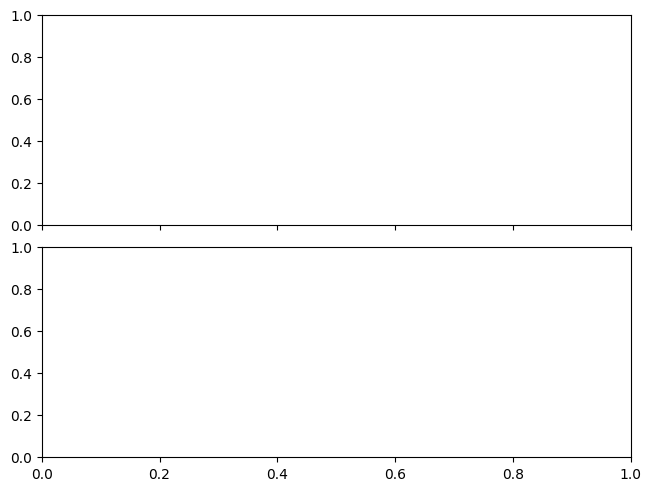

In [5]:
if quick_show == False:

    # parameters for fit function (guess waist / z-pos)
    fit_paramsx1 = np.amin(FWHM_x), z[np.argmin(FWHM_x)]
    fit_paramsy1 = np.amin(FWHM_y), z[np.argmin(FWHM_y)]
    # calculate beam waist fit for FWHM & 1/e^2 (um)
    xw, xw_err = ff.fithyp(z, np.ravel(FWHM_x), fit_paramsx1)
    yw, yw_err = ff.fithyp(z, np.ravel(FWHM_y), fit_paramsy1)
    # parameters for fit function (guess waist / z-pos)
    fit_paramsx2 = np.amin(over_e2x), z[np.argmin(over_e2x)]
    fit_paramsy2 = np.amin(over_e2y), z[np.argmin(over_e2y)]
    # calculate beam waist fit for FWHM & 1/e^2 (um)
    exw, exw_err = ff.fithyp(z, np.ravel(over_e2x), fit_paramsx2)
    eyw, eyw_err = ff.fithyp(z, np.ravel(over_e2y), fit_paramsy2)
    e2xw = np.sqrt(2/np.log(2)) * xw[0]
    e2yw = np.sqrt(2/np.log(2)) * yw[0]

    # calculate rayleigh range (um)
    zr_x = (np.pi * xw[0] ** 2) / ff.wavelength
    zr_y = (np.pi * yw[0] ** 2) / ff.wavelength
    # calculate beam divergence (deg)
    theta_x = (ff.wavelength / (np.pi * xw[0])) * 180/np.pi
    theta_y = (ff.wavelength / (np.pi * yw[0])) * 180/np.pi

    # print fit to the command line
    print('x FWHM waist = ' + '%.2f ' % xw[0] + 'p/m ' + '%.2f mm' % xw_err[0] + ' located at ' + '%.2f' % (xw[1])+ ' p/m ' + '%.2f mm' % (xw_err[1]))
    print('y FWHM waist = ' + '%.2f ' % yw[0] + 'p/m ' + '%.2f mm' % yw_err[0] + ' located at ' + '%.2f' % (yw[1])+ ' p/m ' + '%.2f mm' % (yw_err[1]))
    print('x rayleigh range = ' + '%.2f mm ' % zr_x + 'with divergence angle = ' + '%.2f deg' % theta_x)
    print('y rayleigh range = ' + '%.2f mm ' % zr_y + 'with divergence angle = ' + '%.2f deg' % theta_y)
    print('x 1/e^2 waist = ' + '%.2f ' % e2xw + 'p/m ' + '%.2f mm' % xw_err[0])
    print('y 1/e^2 waist = ' + '%.2f ' % e2yw + 'p/m ' + '%.2f mm' % yw_err[0])

    # append new data to original and write to file
    img_idx = (np.arange(1, len(image_list), 2)).reshape(len(FWHM),1)
    data_out = np.concatenate((img_idx, FWHM_x, over_e2x, FWHM_y, over_e2y), axis=1)
    col_name = ['Image', 'x FWHM', 'x 1/e^2', 'y FWHM', 'y 1/e^2']
    df_out = pd.DataFrame(data=data_out, columns=col_name) 

    # plot fit to data
    z_plot = np.linspace(start=-1.5*zr_x, stop=1.5*zr_x, num=1000, endpoint=True) + xw[1]
    # plot beam diameter and waist fit
    fig_1, ax_1 = mp.subplots(nrows=2, ncols=1, sharex='all', sharey='all', constrained_layout=True)
    ax_1[0].errorbar(z, over_e2x, yerr = np.ravel(e2x_err), label='1/e^2 Diameter in x', markersize=5, color='red', fmt='x')
    ax_1[0].plot(z_plot, ff.hyperbolic(z_plot, exw[0], exw[1]), linestyle='--', label='1/e^2 x Fit', color='red')
    ax_1[1].errorbar(z, over_e2y, yerr = np.ravel(e2y_err), label='1/e^2 Diameter in y', markersize=5, color='blue', fmt='x')
    ax_1[1].plot(z_plot, ff.hyperbolic(z_plot, eyw[0], eyw[1]), linestyle='--', label='1/e^2 y Fit', color='blue')
    ax_1[0].errorbar(z, FWHM_x, yerr = np.ravel(FWHM_xerr), label='FWHM Diameter in y', markersize=5, color='green', fmt='x')
    ax_1[0].plot(z_plot, ff.hyperbolic(z_plot, xw[0], xw[1]), linestyle='--', label='FWHM x Fit', color='green')
    ax_1[1].errorbar(z, FWHM_y, yerr = np.ravel(FWHM_yerr), label='FWHM Diameter in y', markersize=5, color='orange', fmt='x')
    ax_1[1].plot(z_plot, ff.hyperbolic(z_plot, yw[0], yw[1]), linestyle='--', label='FWHM y Fit', color='orange')

    # format plots
    fig_1.suptitle('Beam Waist Fit to Data')
    for ax in ax_1:
        ax.set(xlabel='Change in Camera Position (mm)', ylabel='Beam Diameter (mm)')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True)

    if plot_save == True:
        fig_1.savefig(fname=path + folder + '_' + 'beam_waist_fit.pdf', dpi='figure', format='pdf')

# array for fit to data
    x = np.arange(1, imsize[0] + 1, 1)
    y = np.arange(1, imsize[1] + 1, 1)

# plot gaussian fit to data  
for index in range(array_len):
    
    # define figure and axes
    fig_2, ax_2 = mp.subplots(figsize=(5, 5))
    # main figure original image
    ax_2.imshow(np.transpose(data[index,: , :]))
    # add top and left subplots
    divider = make_axes_locatable(ax_2)
    ax_fitx = divider.append_axes("top", 1, pad=0.1, sharex=ax_2)
    ax_fity = divider.append_axes("right", 1, pad=0.1, sharey=ax_2)
    # remove corresponding axes labels
    ax_fitx.xaxis.set_tick_params(labelbottom=False)
    ax_fity.yaxis.set_tick_params(labelleft=False)
    # plot data
    ax_fitx.plot(x, ff.gaussian(x, *fit_data[index, 0, :]), label='Fit in X')
    ax_fitx.plot(x, data[index, :, round(fit_data[index, 1, 1])], label='X Data')
    ax_fity.plot(ff.gaussian(y, *fit_data[index, 1, :]), y, label='Fit in Y')
    ax_fity.plot(data[index, round(fit_data[index, 0, 1]), :], y, label='Y Data')
    # axis label formatting
    ticks = np.linspace(start=0, stop=np.max(data[index]), num=4)
    ax_fitx.set_yticks(ticks)
    ax_fity.set_xticks(ticks)
    ax_2.set_xticks(np.arange(0, imsize[0], 150))
    ax_2.set_yticks(np.arange(0, imsize[1], 150))
    # set limits
    llim = round(fit_data[index, 0, 1]) - 4 * round(fit_data[index, 0, 2])
    rlim = round(fit_data[index, 0, 1]) + 4 * round(fit_data[index, 0, 2])
    tlim = round(fit_data[index, 1, 1]) - 4 * round(fit_data[index, 1, 2])
    blim = round(fit_data[index, 1, 1]) + 4 * round(fit_data[index, 1, 2])
    ax_2.set_xlim(left=llim, right=rlim)
    ax_2.set_ylim(top=tlim, bottom=blim)
    # add grid lines
    ax_fitx.grid(True)
    ax_fity.grid(True)
    ax_2.grid(True, color='silver', linewidth=0.5)
    # format labels
    ax_2.set(xlabel='Pixels', ylabel='Pixels')
    ax_fitx.set(ylabel='Signal')
    ax_fity.set(xlabel='Signal')
    if quick_show == 0:
        fig_2.suptitle('Image ' + str(img_idx[index]) + ' at ' + str((z[index]/1000)) + ' mm')
    else:
        fig_2.suptitle('Image ' + str(img_idx[index]) + ' waist ' + str((over_e2x[index]/1000)) + ' mm')

    ax_fitx.legend(loc='best', fontsize=8)
    ax_fity.legend(loc='best', fontsize=8)

    if plot_save == True:
        fig_2.savefig(fname=path + folder + '_' + str(img_idx[index]) + 'fit.pdf', dpi='figure', format='pdf')

if plot_show == True:
        mp.show()

Save Data to Excel

In [ ]:
if excel_save == 1:
    # append new data to original and write to file
    img_idx = (np.arange(1, len(image_list), 2)).reshape(len(FWHM),1)
    data_out = np.concatenate((img_idx, FWHM_x, over_e2x, FWHM_y, over_e2y), axis=1)
    col_name = ['Image', 'x FWHM', 'x 1/e^2', 'y FWHM', 'y 1/e^2']
    df_out = pd.DataFrame(data=data_out, columns=col_name)
    if quick_show == 0:
        # write waist fit data to original file
        with pd.ExcelWriter((path + xl_file[0]), engine='openpyxl', mode='a') as writer:
            df_out.to_excel(writer, sheet_name='Fit Data', index=False)
    else:
        # write waist data to original file
        with pd.ExcelWriter((path + xl_file[0]), engine='openpyxl', mode='w') as writer:
            df_out.to_excel(writer, sheet_name='Beam Waist', index=False)